improvements : ordinal categorical encoded with numbers + skewness solved + robust scaler instead of StandardScaler (lotfrontage included

1. Import useful libraries

In [1]:
# Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p
import warnings
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline


1. Dataset import

In [2]:
#bring in the six packs
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

2. Dataset Analyse

In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

In [6]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

3. Outliers

Text(0, 0.5, 'SalePrice')

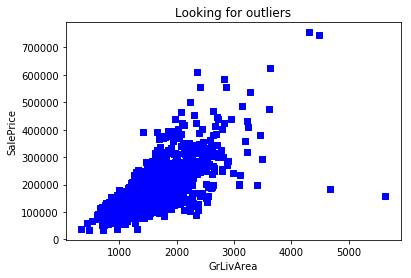

In [7]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

In [8]:
# Removing outliers
train = train[train.GrLivArea < 4000]

4. Saleprice Analyse

In [9]:
train['SalePrice'].describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba1b392da0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba1b3a1470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba40accda0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba1b3a1b00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba1b3a1e48>],
 'means': []}

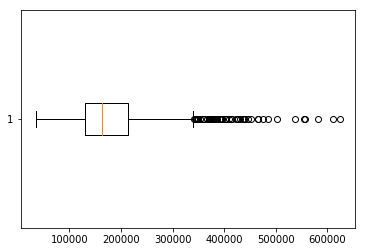

In [10]:
plt.boxplot(train['SalePrice'], vert=False)


 mu = 180151.23 and sigma = 76670.25



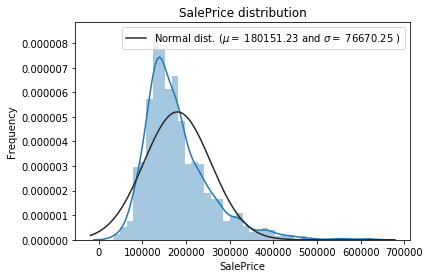

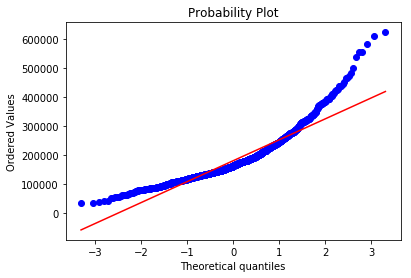

In [11]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [12]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.565959
Kurtosis: 3.885283


In [13]:
train['SalePrice'] = np.log1p (train['SalePrice'])


 mu = 12.02 and sigma = 0.40



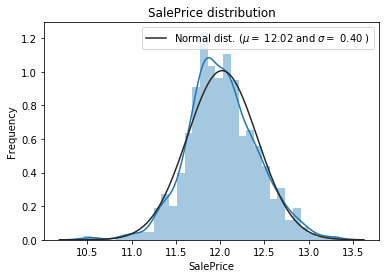

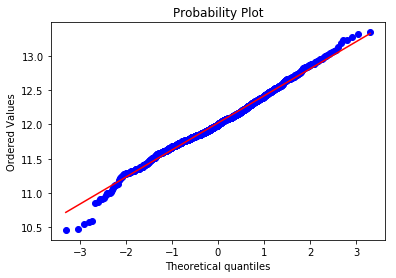

In [14]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

5. Relationship between SalePrice and some other variables

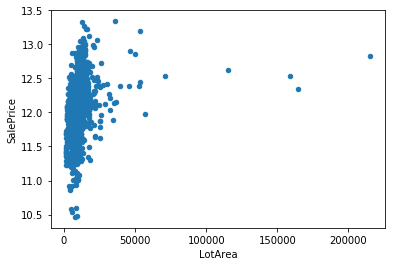

In [15]:
#scatter plot LotArea/saleprice
var = 'LotArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice');

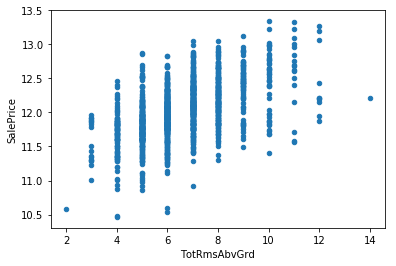

In [16]:
#scatter plot TotRmsAbvGrd/saleprice
var = 'TotRmsAbvGrd'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice');

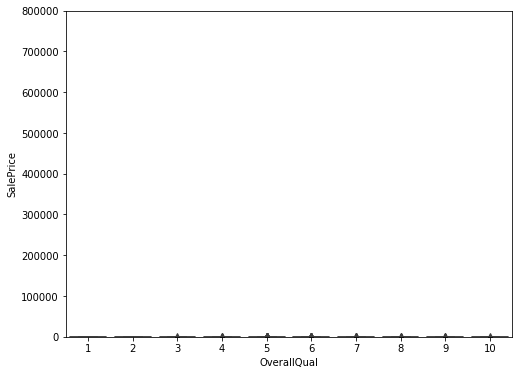

In [17]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

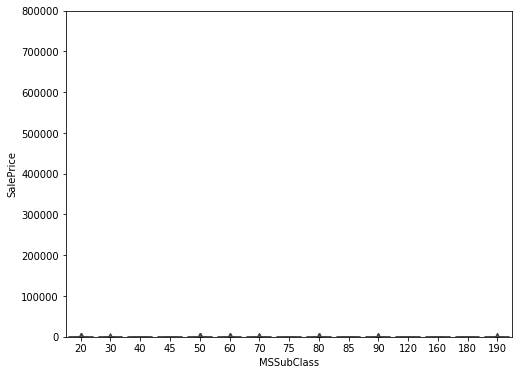

In [18]:
#box plot MSSubClass/saleprice
var = 'MSSubClass'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

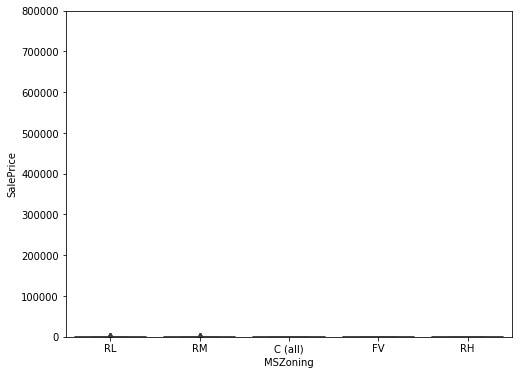

In [19]:
#box plot MSZoning/saleprice
var = 'MSZoning'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

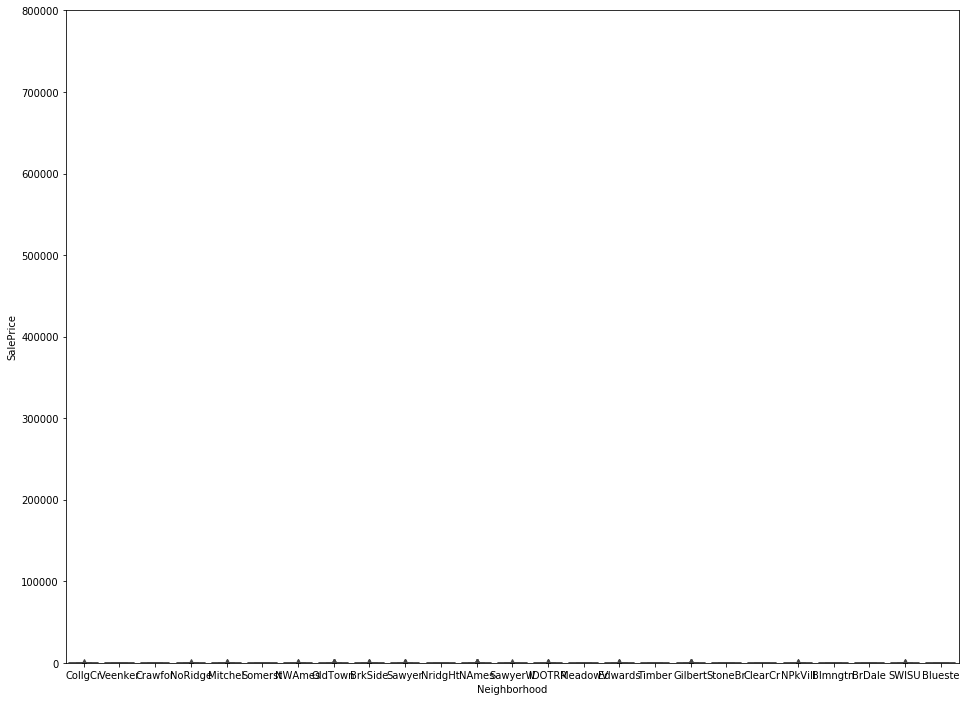

In [20]:
#box plot Neighborhood/saleprice
var = 'Neighborhood'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

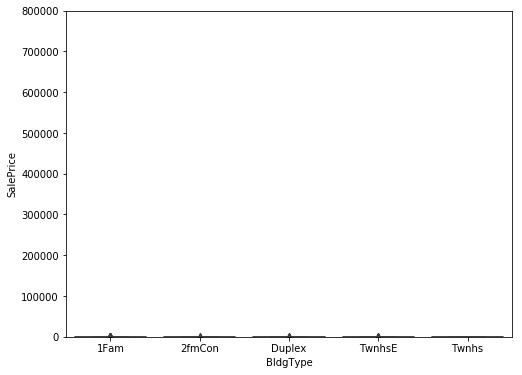

In [21]:
#box plot BldgType/saleprice
var = 'BldgType'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

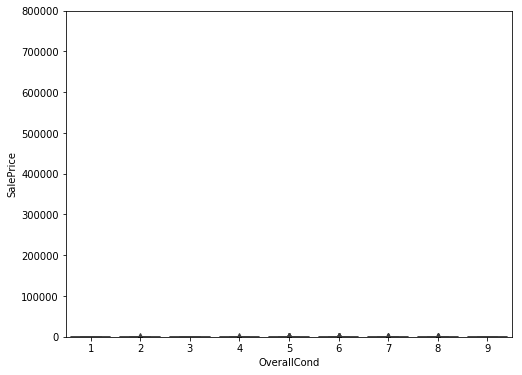

In [22]:
#box plot OverallCond/saleprice
var = 'OverallCond'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


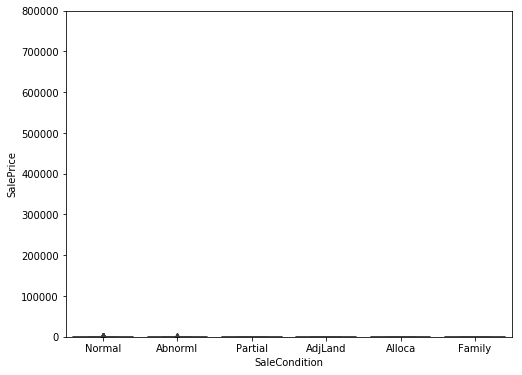

In [23]:
#box plot SaleCondition/saleprice
var = 'SaleCondition'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

5. Corrélation entre les variables

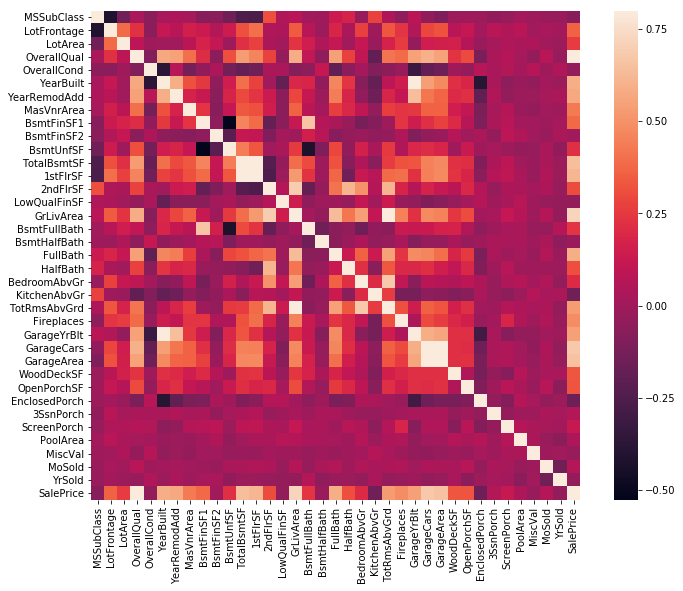

In [24]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

6. Features Engineering

In [25]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_trainf = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 79)


In [26]:
#missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageFinish,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageCond,159,0.054545


PoolQC

In [27]:
all_data['PoolQC'].value_counts()

Ex    3
Gd    3
Fa    2
Name: PoolQC, dtype: int64

Only 8 values are completed. Let's compare this with PoolArea

In [28]:
all_data['PoolArea'].value_counts()

0      2904
561       1
519       1
800       1
738       1
648       1
576       1
512       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64

Here there are 11 values different than 0...

In [29]:
all_data[['PoolArea','PoolQC']].loc[all_data['PoolArea'] > 0]

,PoolArea,PoolQC
197,512,Ex
808,648,Fa
1168,576,Gd
1382,519,Fa
1419,738,Gd
1970,144,Ex
2416,368,NaN
2499,444,NaN
2569,228,Ex
2595,561,NaN


This is reassuring. The lines filled for PoolQC correpond to lines different than null for PoolArea.
But it means that 3 lines have a PoolArea different than 0 but with PoolQC not filled.

I choose to fill them with 'Gd', which is the mean and median of existing values.
I will consider that the null values for PoolQC means they have no pool (considering that the big majority of people don't have a pool) and fill them to NA

In [30]:
all_data.loc[all_data.index[2416],'PoolQC'] = 'Gd'
all_data.loc[all_data.index[2499],'PoolQC'] = 'Gd'
all_data.loc[all_data.index[2595],'PoolQC'] = 'Gd'

In [31]:
all_data[['PoolArea','PoolQC']].loc[all_data['PoolArea'] > 0]

,PoolArea,PoolQC
197,512,Ex
808,648,Fa
1168,576,Gd
1382,519,Fa
1419,738,Gd
1970,144,Ex
2416,368,Gd
2499,444,Gd
2569,228,Ex
2595,561,Gd


In [32]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [33]:
all_data['PoolQC'].value_counts()

None    2904
Gd         6
Ex         3
Fa         2
Name: PoolQC, dtype: int64

MiscFeature

In [34]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

Alley

In [35]:
all_data["Alley"] = all_data["Alley"].fillna("None")

Fence

In [36]:
all_data["Fence"] = all_data["Fence"].fillna("None")

FireplaceQu

In [37]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage

For this field, I had a look on the Kernel of Sevign who propose a method, assuming that the lot frontage in a neighborhood should almost be the same for every lot. Let's analyse this by ploting the box plot of Lotfrontage for each neaighborhood.

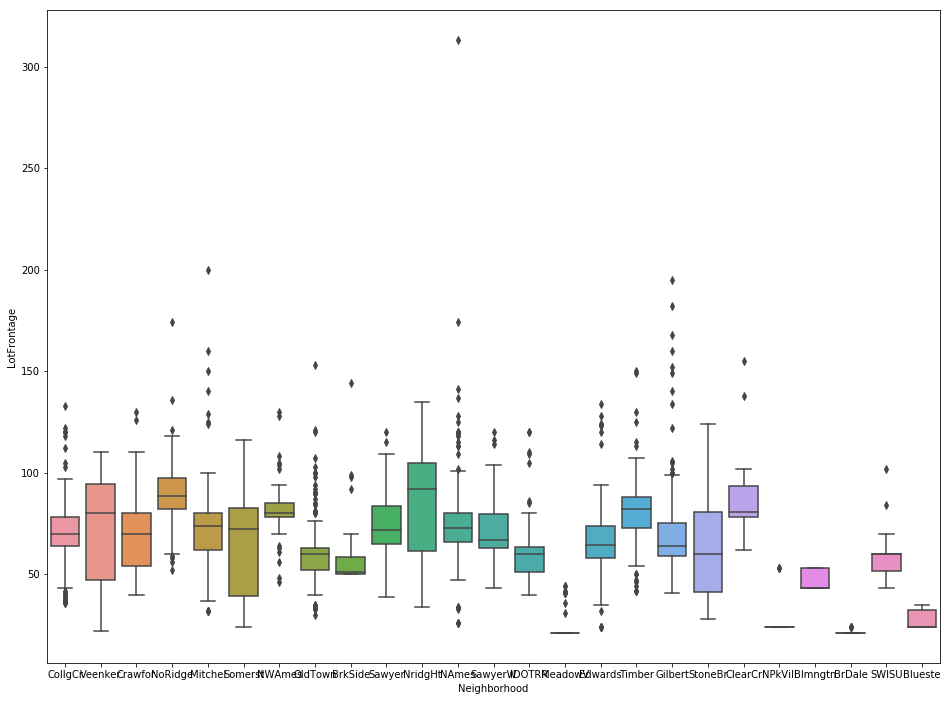

In [38]:
#box plot overallqual/saleprice
var = 'Neighborhood'
data = pd.concat([all_data['LotFrontage'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sns.boxplot(x=var, y="LotFrontage", data=data)
#fig.axis(ymin=0, ymax=800000);

Regarding the previous graph, I'm not convinced this is the right method.
Let's try to do a linear regression to predict missing values.

GarageType, GarageFinish, GarageQual and GarageCond

In [39]:
all_data["GarageType"] = all_data["GarageType"].fillna("None")
all_data["GarageFinish"] = all_data["GarageFinish"].fillna("None")
all_data["GarageQual"] = all_data["GarageQual"].fillna("None")
all_data["GarageCond"] = all_data["GarageCond"].fillna("None")

GarageYrBlt

In [40]:
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)

BsmtXXX

As the numbers of blanks for all columns BsmtXXX are almost the same, we could think that they correspond to the same rows. Let's check it. 

In [41]:
all_data[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].loc[pd.isnull(all_data['BsmtExposure']) | pd.isnull(all_data['BsmtCond']) | pd.isnull(all_data['BsmtQual']) | pd.isnull(all_data['BsmtFinType2']) | pd.isnull(all_data['BsmtFinType1']) ]

,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
182,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
259,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
332,No,TA,Gd,NaN,GLQ,1124.0,479.0,1603.0,3206.0,1.0,0.0
342,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
362,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


Unfortunetely, we can notice that the empty lines are not the same contrary to what we could expect.
We can defferienciate two cases :
* the lines are all empties : we can assume that there is no basement
* At least one line is filled : there is missing data that we need to treat

Let's first solve the first case by filling the cells by "None"

In [42]:
all_data.loc[pd.isnull(all_data['BsmtExposure']) & pd.isnull(all_data['BsmtCond']) & pd.isnull(all_data['BsmtQual']) & pd.isnull(all_data['BsmtFinType2']) & pd.isnull(all_data['BsmtFinType1']),['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']] = 'None'

In [43]:
all_data[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']].loc[pd.isnull(all_data['BsmtExposure']) | pd.isnull(all_data['BsmtCond']) | pd.isnull(all_data['BsmtQual']) | pd.isnull(all_data['BsmtFinType2']) | pd.isnull(all_data['BsmtFinType1']) ]

,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
332,No,TA,Gd,NaN,GLQ
946,NaN,TA,Gd,Unf,Unf
1483,NaN,TA,Gd,Unf,Unf
2036,Mn,NaN,Gd,Rec,GLQ
2181,No,NaN,TA,Unf,BLQ
2213,No,Fa,NaN,Unf,Unf
2214,No,TA,NaN,Unf,Unf
2344,NaN,TA,Gd,Unf,Unf
2520,Av,NaN,TA,Unf,ALQ


We solved most of the empty rows. Let's now analysing column by column the remaining blanks

* BsmtExposure

In [44]:
all_data['BsmtExposure'].value_counts()

No      1904
Av       417
Gd       273
Mn       239
None      79
Name: BsmtExposure, dtype: int64

The huge majority of basements have no exposure, let's fill the 3 blanks with "No"

In [45]:
all_data.loc[all_data.index[946],'BsmtExposure'] = 'No'
all_data.loc[all_data.index[1483],'BsmtExposure'] = 'No'
all_data.loc[all_data.index[2344],'BsmtExposure'] = 'No'

* BsmtCond

In [46]:
all_data['BsmtCond'].value_counts()

TA      2602
Gd       122
Fa       104
None      79
Po         5
Name: BsmtCond, dtype: int64

The huge majority of basements have a "typical" condition, let's fill the blanks with "TA"

In [47]:
all_data.loc[all_data.index[2036],'BsmtCond'] = 'TA'
all_data.loc[all_data.index[2181],'BsmtCond'] = 'TA'
all_data.loc[all_data.index[2520],'BsmtCond'] = 'TA'

* BsmtQual

In [48]:
all_data['BsmtQual'].value_counts()

TA      1283
Gd      1209
Ex       254
Fa        88
None      79
Name: BsmtQual, dtype: int64

Let's take the median which is "Gd" to fill the blanks

In [49]:
all_data.loc[all_data.index[2213],'BsmtQual'] = 'Gd'
all_data.loc[all_data.index[2214],'BsmtQual'] = 'Gd'

* BsmtFinType2

In [50]:
all_data['BsmtFinType2'].value_counts()

Unf     2489
Rec      105
LwQ       87
None      79
BLQ       68
ALQ       52
GLQ       34
Name: BsmtFinType2, dtype: int64

The huge majority of basements have an unfinished type 2, let's fill the blanks with "Unf"

In [51]:
all_data.loc[all_data.index[332],'BsmtFinType2'] = 'Unf'

MasVnrArea and MasVnrType

In [52]:
all_data[['MasVnrArea','MasVnrType']].loc[pd.isnull(all_data['MasVnrArea']) | pd.isnull(all_data['MasVnrType'])]

,MasVnrArea,MasVnrType
234,NaN,NaN
528,NaN,NaN
649,NaN,NaN
934,NaN,NaN
971,NaN,NaN
975,NaN,NaN
1240,NaN,NaN
1275,NaN,NaN
1687,NaN,NaN
1702,NaN,NaN


In [53]:
all_data['MasVnrArea'].value_counts()

0.0       1737
120.0       15
200.0       13
176.0       13
180.0       12
          ... 
1290.0       1
532.0        1
322.0        1
251.0        1
217.0        1
Name: MasVnrArea, Length: 441, dtype: int64

In [54]:
all_data['MasVnrType'].value_counts()

None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

We notice different cases to solve :
* Both MasVnrArea and MasVnrType are empty : we will consider that there is no masonry and set to 0 and None
* MasVnrArea is different than 0 and MasVnrType is empty or 'None' : we will set MasVnrType to BrkFace

In [55]:
all_data.loc[(pd.isnull(all_data['MasVnrArea']) & pd.isnull(all_data['MasVnrType'])),['MasVnrType']] = 'None'
all_data.loc[(pd.isnull(all_data['MasVnrArea'])),['MasVnrArea']] = 0
all_data.loc[(all_data['MasVnrArea'] != 0) & (all_data['MasVnrType'] == 'None'),['MasVnrType']] = 'BrkFace'
all_data.loc[all_data.index[2606],'MasVnrType'] = 'BrkFace'

In [56]:
all_data['MasVnrArea'].value_counts()

0.0       1760
120.0       15
200.0       13
176.0       13
180.0       12
          ... 
1290.0       1
532.0        1
322.0        1
251.0        1
217.0        1
Name: MasVnrArea, Length: 441, dtype: int64

In [57]:
all_data['MasVnrType'].value_counts()

None       1757
BrkFace     886
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

In [58]:
all_data[['MasVnrArea','MasVnrType']].loc[pd.isnull(all_data['MasVnrArea']) | pd.isnull(all_data['MasVnrType'])]

,MasVnrArea,MasVnrType


MSZoning

In [59]:
all_data[['MSZoning','Neighborhood']].loc[pd.isnull(all_data['MSZoning'])]

,MSZoning,Neighborhood
1911,NaN,IDOTRR
2212,NaN,IDOTRR
2246,NaN,IDOTRR
2900,NaN,Mitchel


Intuitively, we can suppose that MSZoning depends on the Neighborhood. Let's check it

In [60]:
all_data['MSZoning'].loc[all_data['Neighborhood'] == 'IDOTRR'].value_counts()

RM         68
C (all)    22
Name: MSZoning, dtype: int64

In [61]:
all_data['MSZoning'].loc[all_data['Neighborhood'] == 'Mitchel'].value_counts()

RL    104
RM      9
Name: MSZoning, dtype: int64

The intuition we had seems to be right. 
The neighborhood 'IDOTRR' seems to be mainly Residential Medium Density, so we can fill the blanks with "RM".
The neighborhood 'Mitchel' seems to be mainly Residential Low Density, so we can fill the blank with "RL"

In [62]:
all_data.loc[all_data.index[1911],'MSZoning'] = 'RM'
all_data.loc[all_data.index[2212],'MSZoning'] = 'RM'
all_data.loc[all_data.index[2246],'MSZoning'] = 'RM'
all_data.loc[all_data.index[2900],'MSZoning'] = 'RL'

Let's check if it worked

In [63]:
all_data['MSZoning'].loc[all_data['Neighborhood'] == 'IDOTRR'].value_counts()

RM         71
C (all)    22
Name: MSZoning, dtype: int64

In [64]:
all_data['MSZoning'].loc[all_data['Neighborhood'] == 'Mitchel'].value_counts()

RL    105
RM      9
Name: MSZoning, dtype: int64

BsmtHalfBath, BsmtFullBath, TotalBsmtSF, BsmtUnfSF, BsmtFinSF1, BsmtFinSF2 

In [65]:
all_data[['BsmtHalfBath','BsmtFullBath','TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2', 'BsmtExposure', 'BsmtCond', 'BsmtQual']].loc[pd.isnull(all_data['BsmtHalfBath']) | pd.isnull(all_data['BsmtFullBath']) | pd.isnull(all_data['TotalBsmtSF']) | pd.isnull(all_data['BsmtUnfSF']) | pd.isnull(all_data['BsmtFinSF1']) | pd.isnull(all_data['BsmtFinSF2'])]

,BsmtHalfBath,BsmtFullBath,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,BsmtExposure,BsmtCond,BsmtQual
2116,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
2184,NaN,NaN,0.0,0.0,0.0,0.0,None,None,None


These lines have already been treated. We considered there is no basement.

In [66]:
all_data.loc[all_data.index[2116],['BsmtHalfBath','BsmtFullBath','TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2']] = 0
all_data.loc[all_data.index[2184],['BsmtHalfBath','BsmtFullBath','TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2']] = 0

Utilities

In [67]:
all_data['Utilities'].value_counts()

AllPub    2912
NoSeWa       1
Name: Utilities, dtype: int64

As the huge majority is 'AllPub', we can fill the blanks with this value

In [68]:
all_data['Utilities'].loc[pd.isnull(all_data['Utilities'])] = 'AllPub'

In [69]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

Functional

In [70]:
all_data['Functional'].value_counts()

Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

Let's fill the blanks with the most common value : Typical

In [71]:
all_data['Functional'].loc[pd.isnull(all_data['Functional'])] = 'Typ'

In [72]:
all_data['Functional'].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

Electrical

In [73]:
all_data['Electrical'].value_counts()

SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [74]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [75]:
all_data['Electrical'].value_counts()

SBrkr    2668
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

Exterior1st and Exterior2nd

In [76]:
all_data['Exterior1st'].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64

In [77]:
all_data['Exterior2nd'].value_counts()

VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

Let's fill the blanks with the most common value

In [78]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

KitchenQual

In [79]:
all_data['KitchenQual'].value_counts()

TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64

We fill the blank with the median and most common value : TA

In [80]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

GarageArea and GarageCars

In [81]:
all_data[['GarageArea','GarageCars','GarageQual','GarageCond']].loc[pd.isnull(all_data['GarageArea']) | pd.isnull(all_data['GarageCars'])]

,GarageArea,GarageCars,GarageQual,GarageCond
2572,NaN,NaN,None,None


The value for GarageQual and GarageCond is set to None which means no Garage. Let's set the blanks to 0

In [82]:
for col in ('GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

SaleType

In [83]:
all_data['SaleType'].value_counts()

WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [84]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

LotFrontage

Transform some quantitative features into numeric

In [85]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['MoSold'] = all_data['MoSold'].astype(str)

In [86]:
#all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

In [87]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: '1' if x > 0 else '0')
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: '1' if x > 0 else '0')
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: '1' if x > 0 else '0')
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: '1' if x > 0 else '0')
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: '1' if x > 0 else '0')

Skewness

In [88]:
numeric_feats = all_data.dtypes[all_data.dtypes != object].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892


skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index

for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], boxcox_normmax(all_data[feat] + 1))

In [89]:
skew=all_data.select_dtypes(include=['int','float']).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_df=pd.DataFrame({'Skew':skew})
skewed_df=skew_df[(skew_df['Skew']>0.5)|(skew_df['Skew']<-0.5)]
skewed_df.index

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'Total_porch_sf', '1stFlrSF', 'Total_sqr_footage', 'LotFrontage',
       'GrLivArea', 'BsmtFinSF1', 'TotalSF', 'BsmtUnfSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'TotalBsmtSF', 'BsmtFullBath',
       'OverallCond', 'YearBuilt', 'GarageYrBlt'],
      dtype='object')

In [90]:
lam=0.1
for col in ('MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'YearBuilt',
       'GarageYrBlt'):
    all_data[col]=boxcox1p(all_data[col],boxcox_normmax(all_data[col] + 1))

In [91]:
skewness

,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892


In [92]:
all_data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
count,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,...,2915.000000,2915.000000,2.915000e+03,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000
mean,1156.821269,334.741338,0.080238,2.859348,88.701074,1.162321,0.425827,0.042958,60.050241,1.887763,...,507.100111,19.661220,1.348054e+51,1984.240480,2007.793482,3955.512178,2539.589708,1979.143739,2.215437,182.592796
std,383.956821,426.116353,0.712299,0.822707,78.447564,3.250724,0.520041,0.171259,32.683034,4.523125,...,185.951126,23.123056,3.063202e+50,20.897341,1.315615,46.138389,773.270203,727.681251,0.805396,159.748281
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.781511e+50,1950.000000,2006.000000,3830.000000,334.000000,334.000000,1.000000,0.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,37.827915,0.000000,...,400.612900,0.000000,1.132388e+51,1965.000000,2007.000000,3920.000000,2000.000000,1486.000000,1.500000,48.000000
50%,1082.000000,0.000000,0.000000,3.000000,91.261032,0.000000,0.000000,0.000000,59.416234,0.000000,...,486.393417,0.000000,1.331125e+51,1993.000000,2008.000000,3954.000000,2446.000000,1845.000000,2.000000,164.000000
75%,1383.500000,703.500000,0.000000,3.000000,149.222059,0.000000,0.993331,0.000000,82.011499,0.000000,...,619.212875,38.665363,1.664740e+51,2004.000000,2009.000000,4002.000000,2989.500000,2376.000000,2.500000,266.000000
max,5095.000000,1862.000000,7.819171,8.000000,500.189724,14.392175,2.956262,1.140749,153.788315,26.214410,...,2057.860350,152.745099,1.787629e+51,2010.000000,2010.000000,4020.000000,10190.000000,9105.000000,7.000000,1424.000000


In [93]:
all_data

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,856,854,0.000000,None,3,1Fam,TA,No,145.420491,0.000000,...,4006,2566.0,2416.0,3.5,61,0,1,1,1,0
1,1262,0,0.000000,None,3,1Fam,TA,Gd,183.461369,0.000000,...,3952,2524.0,2240.0,2.5,298,0,0,1,1,1
2,920,866,0.000000,None,3,1Fam,TA,Mn,111.370406,0.000000,...,4003,2706.0,2272.0,3.5,42,0,1,1,1,1
3,961,756,0.000000,None,3,1Fam,Gd,No,62.233105,0.000000,...,3885,2473.0,1933.0,2.0,307,0,1,1,1,1
4,1145,1053,0.000000,None,4,1Fam,TA,Av,137.842332,0.000000,...,4000,3343.0,2853.0,3.5,276,0,1,1,1,1
5,796,566,7.116457,None,1,1Fam,TA,No,149.222059,0.000000,...,3988,2158.0,2094.0,2.5,390,0,1,1,1,0
6,1694,0,0.000000,None,3,1Fam,TA,Av,233.099514,0.000000,...,4009,3380.0,3063.0,3.0,312,0,0,1,1,1
7,1107,983,0.000000,None,3,1Fam,TA,Mn,167.258166,4.750300,...,3946,3197.0,2981.0,3.5,667,0,1,1,1,1
8,1022,752,0.000000,None,2,1Fam,TA,No,0.000000,0.000000,...,3881,2726.0,1774.0,2.0,295,0,1,1,1,1
9,1077,0,0.000000,None,2,2fmCon,TA,No,166.146147,0.000000,...,3889,2068.0,1928.0,2.0,4,0,0,1,1,1


Encoding of categorical features

https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

In [94]:
# Encode some categorical features as ordered numbers when there is information in the order
all_data = all_data.replace({"BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                        "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [95]:
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2915, 313)

LotFrontage

Now that we've done all the steps of features engineering, it's time to predict empty values for LotFrontage, using regression algorithm

In [96]:
y = final_features['LotFrontage'].dropna()
X = final_features.dropna().drop('LotFrontage', axis=1)
X_predict = final_features.loc[pd.isnull(final_features['LotFrontage'])].drop('LotFrontage', axis=1)

In [97]:
X.shape

(2429, 312)

In [98]:
X_predict.shape

(486, 312)

In [99]:
y.shape

(2429,)

Regression likes standardized values so let's apply StandardScaler(). I use DataFrameMapper to keep DataFrame format (more information here : http://ryankresse.com/convenient-preprocessing-with-sklearn_pandas-dataframemapper/)

In [100]:
def rmse(targets, predictions):
    return np.sqrt(mean_squared_error(targets,predictions))
rmse_score = make_scorer (rmse, greater_is_better = False)

In [101]:
scaler = RobustScaler ()
X = scaler.fit_transform(X)
X_predict = scaler.transform(X_predict)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 45)

In [103]:
params = {'alpha' : [0.01, 0.1, 1, 10, 100, 1000] }
gridsearch_lasso = GridSearchCV (Lasso(),params, scoring = rmse_score)
gridsearch_lasso.fit(X_train, y_train)
print ("Meilleurs parametres: ", gridsearch_lasso.best_params_)
gridsearch_lasso.score(X_test, y_test)

Meilleurs parametres:  {'alpha': 1000}


-6.824234340548326e+18

In [104]:
params = {'alpha' : [0.01, 0.1, 1, 10, 100, 1000] }
gridsearch_ridge = GridSearchCV (Ridge(),params, scoring = rmse_score)
gridsearch_ridge.fit(X_train, y_train)
print ("Meilleurs parametres: ", gridsearch_ridge.best_params_)
gridsearch_ridge.score(X_test, y_test)

Meilleurs parametres:  {'alpha': 1000}


-6.827088841318885e+18

In [105]:
params = {'alpha' : [0.01, 0.1, 1, 10, 100, 1000], 
          'l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]}
gridsearch_elasticnet = GridSearchCV (ElasticNet(),params, scoring = rmse_score)
gridsearch_elasticnet.fit(X_train, y_train)
print ("Meilleurs parametres: ", gridsearch_elasticnet.best_params_)
gridsearch_elasticnet.score(X_test, y_test)

Meilleurs parametres:  {'alpha': 10, 'l1_ratio': 0.7}


-6.828344458491784e+18

params = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

gridsearch_rdforest = GridSearchCV (RandomForestRegressor(),params, scoring = rmse_score)
gridsearch_rdforest.fit(X_train, y_train)
print ("Meilleurs parametres: ", gridsearch_rdforest.best_params_)
gridsearch_rdforest.score(X_test, y_test)

Best parameters of gridsearch : {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}

In [106]:
rdforest = RandomForestRegressor(bootstrap = True, max_depth = 100, max_features = 3, min_samples_leaf = 3, min_samples_split = 8, n_estimators = 200)
rdforest.fit(X_train,y_train)
print ("R2 score for train set : ", rdforest.score(X_train, y_train))
print ("R2 score for test set : ", rdforest.score(X_test, y_test))

R2 score for train set :  0.2183311468300567
R2 score for test set :  -0.001194224379906128


y_train_rdforest = rdforest.predict(X_train)
y_test_rdforest = rdforest.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdforest, y_train_rdforest - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdforest, y_test_rdforest - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_rdforest, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_rdforest, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [107]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(X_train, y_train)
y_pred = KRR.predict(X_test)
KRR.score (X_test, y_test)

-2.6144354795976096e-05

In [108]:
svr = SVR(kernel='rbf', C=100, gamma=0.001)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr.score(X_test, y_test)

-0.0017174072206169733

params = {'kernel' : ["rbf"],
          'C' : [0.1, 1, 10, 100, 1000, 10000],
          'gamma' :["auto",0.0001, 0.001, 0.01, 0.1] }
gridsearch_svr = GridSearchCV (SVR(),params, scorer = rmse_score)
gridsearch_svr.fit(X_train, y_train)
print ("Meilleurs parametres: ", gridsearch_svr.best_params_)
gridsearch_svr.score(X_test, y_test)

# Classifier with tuned parameteres
clf = svm.SVR(kernel='rbf', C=100, gamma=0.001)

# Set initial scores
acc = 0
acc1 = 0
acc2 = 0

# Defien k-fold object for 10-fold validation
kf = KFold(n_splits=10, shuffle=True, random_state=3) 

# Main evaluator loop over the 10 folds
for trn, tst in kf.split(train):
    
    # Compute benchmark score prediction based on mean neighbourhood LotFrontage
    fold_train_samples = train.iloc[trn]
    fold_test_samples = train.iloc[tst]
    neigh_means = fold_train_samples.groupby('Neighborhood')['LotFrontage'].mean()
    all_mean = fold_train_samples['LotFrontage'].mean()
    y_pred_neigh_means = fold_test_samples.join(neigh_means, on = 'Neighborhood', lsuffix='benchmark')['LotFrontage']
    y_pred_all_mean = [all_mean] * fold_test_samples.shape[0]
    
    # Compute benchmark score prediction based on overall mean LotFrontage
    u1 = ((fold_test_samples['LotFrontage'] - y_pred_neigh_means) ** 2).sum()
    u2 = ((fold_test_samples['LotFrontage'] - y_pred_all_mean) ** 2).sum()
    v = ((fold_test_samples['LotFrontage'] - fold_test_samples['LotFrontage'].mean()) ** 2).sum()
    
    # Perform model fitting 
    clf.fit(X_train.iloc[trn], y_lotFrontage.iloc[trn])
    
    # Record all scores for averaging
    acc = acc + mean_absolute_error(fold_test_samples['LotFrontage'], clf.predict(X_train.iloc[tst]))
    acc1= acc1 + mean_absolute_error(fold_test_samples['LotFrontage'], y_pred_neigh_means)
    acc2 = acc2 + mean_absolute_error(fold_test_samples['LotFrontage'], y_pred_all_mean)

    
print('10-Fold Validation Mean Absolute Error results:')
print('\tSVR: {:.3}'.format(acc/10))
print('\tSingle mean: {:.3}'.format(acc2/10))
print('\tNeighbourhood mean: {:.3}'.format(acc1/10))

The best score seems to be done with ElasticNet algorithm. So, we are going to predict missing values using this trained algorithm.

In [109]:
final_features.loc[final_features["LotFrontage"].isnull(),"LotFrontage"] = gridsearch_elasticnet.predict(X_predict)
#y_predict = gridsearch_elasticnet.predict(X_predict)
#deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

In [110]:
#missing data
total = final_features.isnull().sum().sort_values(ascending=False)
percent = (final_features.isnull().sum()/final_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
hasfireplace_1,0,0.0
Electrical_FuseF,0,0.0
Condition2_Norm,0,0.0
Condition2_PosA,0,0.0
Condition2_PosN,0,0.0
Condition2_RRAe,0,0.0
Condition2_RRAn,0,0.0
Condition2_RRNn,0,0.0
Electrical_FuseA,0,0.0
Electrical_FuseP,0,0.0


In [111]:
scaler_lotfrontage = RobustScaler()
final_features = scaler_lotfrontage.fit_transform(final_features)

In [112]:
train = final_features[:ntrain]
test = final_features[ntrain:]

Now that we preprocessed the data, we can use regression techniques to predict SalePrice data

**6. Apply regression models on SalePrice**

Define the validation strategy

In [113]:
def rmse(targets, predictions):
    return np.sqrt(mean_squared_error(targets,predictions))
rmse_score = make_scorer (rmse, greater_is_better = False)

We split the set in train and test sets

In [114]:
train.shape

(1456, 313)

In [115]:
y_trainf.shape

(1456,)

In [116]:
X_tr, X_val, y_tr, y_val = train_test_split(train, y_trainf, random_state = 3)

Compare base models

In [117]:
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gridsearch_lasso = GridSearchCV (Lasso(),params, scoring=rmse_score)
gridsearch_lasso.fit(X_tr, y_tr)
print ("Meilleurs parametres: ", gridsearch_lasso.best_params_)
gridsearch_lasso.score(X_val, y_val)

Meilleurs parametres:  {'alpha': 0.001}


-0.11580899230755753

In [118]:
params = {'alpha' : [0.0008, 0.009, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006] }
gridsearch_lasso = GridSearchCV (Lasso(),params, scoring=rmse_score)
gridsearch_lasso.fit(X_tr, y_tr)
print ("Meilleurs parametres: ", gridsearch_lasso.best_params_)
gridsearch_lasso.score(X_val, y_val)

Meilleurs parametres:  {'alpha': 0.001}


-0.11580899230755753

In [119]:
lasso = Lasso(alpha = 0.001)
lasso.fit(train, y_trainf)
lasso_pred = np.expm1(lasso.predict(test))
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = lasso_pred
sub.to_csv('submission.csv',index=False)

In [120]:
sub

,Id,SalePrice
0,1461,118927.094833
1,1462,156967.858894
2,1463,182191.402206
3,1464,203259.529526
4,1465,189749.953736
5,1466,170764.277201
6,1467,180857.464978
7,1468,162516.857335
8,1469,195940.430330
9,1470,114807.411742
